In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import sympy as smp
from matplotlib import animation
from matplotlib.animation import PillowWriter
from IPython.display import Image
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
import math

In [2]:
#init_vprinting()

In [3]:
t, m_1, m_2, I_1, I_2, l_1, l_g1, l_g2, g = smp.symbols('t, m_1, m_2, I_1, I_2, l_1, l_g1, l_g2, g')

In [4]:
#Generalized Variables
#theta_1 = smp.Symbol('theta_1')
#theta_2 = smp.Symbol('theta_2')
theta_1, theta_2 = smp.symbols(r'\theta_1 \theta_2', cls=smp.Function)

Define $\theta(t)$ and $\dot{\theta}(t)$ and $\ddot{\theta}(t)$

In [5]:
theta_1 = theta_1(t)
theta_2 = theta_2(t)
theta_1d = smp.diff(theta_1,t)
theta_2d = smp.diff(theta_2,t)
theta_1dd = smp.diff(theta_1d,t)
theta_2dd = smp.diff(theta_2d,t)

In [6]:
theta_1, theta_2, theta_1d, theta_2d, theta_1dd, theta_2dd 

(\theta_1(t),
 \theta_2(t),
 Derivative(\theta_1(t), t),
 Derivative(\theta_2(t), t),
 Derivative(\theta_1(t), (t, 2)),
 Derivative(\theta_2(t), (t, 2)))

Define the $x$ and $y$ in function of...

In [7]:
x1 = (l_g1)*smp.cos(theta_1)
y1 = (l_g1)*smp.sin(theta_1)
x2 = (l_1)*smp.cos(theta_1) + (l_g2)*smp.cos(theta_1+theta_2)
y2 = (l_1)*smp.sin(theta_1) + (l_g2)*smp.sin(theta_1+theta_2)
y2

l_1*sin(\theta_1(t)) + l_g2*sin(\theta_1(t) + \theta_2(t))

Define both kinetic and potential energy:

* Kinetic energy $T$ comes from the motion of the two arms


In [8]:
T1 = smp.Rational(1/2) * m_1 * (smp.diff(x1,t)**2 + smp.diff(y1,t)**2) + smp.Rational(1/2) * I_1 * theta_1d**2

T2 = smp.Rational(1,2) * m_2 * (smp.diff(x2,t)**2 + smp.diff(y2,t)**2) + smp.Rational(1/2) * I_2 * (theta_1d**2 + theta_2d**2)

T = T1 + T2


* Potential energy $V$ comes from both the gravitational potential energy of the masses $mgy$ 

In [9]:
V1 = m_1*l_g1*g*smp.sin(theta_1)
V2 = m_2*g*(l_1*smp.sin(theta_1) + l_g2*smp.sin(theta_1+theta_2))
V = V1 + V2

Now we can look at the Lagrangian

In [10]:
L = T - V
L

I_1*Derivative(\theta_1(t), t)**2/2 + I_2*(Derivative(\theta_1(t), t)**2 + Derivative(\theta_2(t), t)**2)/2 - g*l_g1*m_1*sin(\theta_1(t)) - g*m_2*(l_1*sin(\theta_1(t)) + l_g2*sin(\theta_1(t) + \theta_2(t))) + m_1*(l_g1**2*sin(\theta_1(t))**2*Derivative(\theta_1(t), t)**2 + l_g1**2*cos(\theta_1(t))**2*Derivative(\theta_1(t), t)**2)/2 + m_2*((-l_1*sin(\theta_1(t))*Derivative(\theta_1(t), t) - l_g2*(Derivative(\theta_1(t), t) + Derivative(\theta_2(t), t))*sin(\theta_1(t) + \theta_2(t)))**2 + (l_1*cos(\theta_1(t))*Derivative(\theta_1(t), t) + l_g2*(Derivative(\theta_1(t), t) + Derivative(\theta_2(t), t))*cos(\theta_1(t) + \theta_2(t)))**2)/2

Get Lagrange's equations

$$\frac{\partial L}{\partial \theta_1} - \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_1}} = 0$$
$$\frac{\partial L}{\partial \theta_2} - \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_2}} = 0$$

In [11]:
LE1 = smp.diff(L, theta_1) - smp.diff(smp.diff(L, theta_1d), t).simplify()
LE2 = smp.diff(L, theta_2) - smp.diff(smp.diff(L, theta_2d), t).simplify()

Solve Lagranges equations (this assumes that `LE1` and `LE2` are both equal to zero)

* We solve these equations (which are **linear** in $\ddot{\theta_1}$ and $\ddot{\theta_2}$) for $\ddot{\theta_1}$ and $\ddot{\theta_2}$.

In [12]:
sols = smp.solve([LE1, LE2], (theta_1dd , theta_2dd ),
                simplify=False, rational=False)

Now we have 

* $\frac{d^2 \theta_1}{dt^2} = ...$
* $\frac{d^2 \theta_2}{dt^2} = ...$

These are two second order ODEs! In python we can only solve systems of first order ODEs. Any system of second order ODEs can be converted as follows:

1. Define $z_1 = d\theta_1/dt$ and $z_2=d\theta_2/dt$
2. Then $dz_1/dt = d^2\theta_1/dt^2$ and $dz_2/dt = d^2\theta_2/dt^2$

Now we get a system of 4 first order ODEs (as opposed to 2 second order ones)

* $d z_1/dt = ...$
* $d\theta_1/dt = z_1$
* $d z_2/dt = ...$
* $d\theta_2/dt = z_1$

We need to convert the **symbolic** expressions above to numerical functions so we can use them in a numerical python solver. For this we use `smp.lambdify`

In [13]:
dz1dt_f = smp.lambdify((t,g,m_1, m_2, I_1, I_2, l_1, l_g1, l_g2,theta_1,theta_2,theta_1d,theta_2d), sols[theta_1dd])
dz2dt_f = smp.lambdify((t,g,m_1, m_2, I_1, I_2, l_1, l_g1, l_g2,theta_1,theta_2,theta_1d,theta_2d), sols[theta_2dd])
dthe1dt_f = smp.lambdify(theta_1d, theta_1d)
dthe2dt_f = smp.lambdify(theta_2d, theta_2d)

Now define $\vec{S} = (\theta_1, z_1, \theta_2, z_2)$. IF we're going to use an ODE solver in python, we need to write a function that takes in $\vec{S}$ and $t$ and returns $d\vec{S}/dt$. In other words, we need to define $d\vec{S}/dt (\vec{S}, t)$

* Our system of ODEs can be fully specified using $d\vec{S}/dt$ and depends only on $\vec{S}$ and $t$

In [14]:
def dSdt(S, t, g, m_1, m_2, I_1, I_2, l_1, l_g1, l_g2):
    theta_1, z1, theta_2, z2 = S
    return [
        dthe1dt_f(z1),
        dz1dt_f(t,g,m_1, m_2, I_1, I_2, l_1, l_g1, l_g2,theta_1,theta_2,z1,z2),
        dthe2dt_f(z2),
        dz2dt_f(t,g,m_1, m_2, I_1, I_2, l_1, l_g1, l_g2,theta_1,theta_2,z1,z2),
    ]

Solve the system of ODEs using scipys `odeint` method

In [15]:
t = np.linspace(0, 10, 1001) # s
g = 9.81 #m/s^2
m_1 = 1.0 # kg
m_2 = 1.0 # kg
I_1 = 1.0 
I_2 = 1.0
l_1 = 1.0 # m
l_g1 = smp.Rational(1/2)*l_1 # m
l_g2 = smp.Rational(1/2)*l_1 # m


#y0=[-smp.Rational(1/4)*math.pi, 0.0,-smp.Rational(1/3)*math.pi, 0.0]
y0=[0.1*math.pi, 0.0, 0.1*math.pi, 0.0]
#ans = odeint(dSdt, y0=[1, -1, -1, 1], t=t, args=(g, k, L0, m1, m2, m3, l1, l2))
ans = odeint(dSdt, y0, t=t, args=(g,m_1, m_2, I_1, I_2, l_1, l_g1, l_g2))

In [18]:
the1 = ans.T[0]*smp.Rational(180/math.pi)
#the1 = ans.T
the2 = ans.T[1]*smp.Rational(180/math.pi)

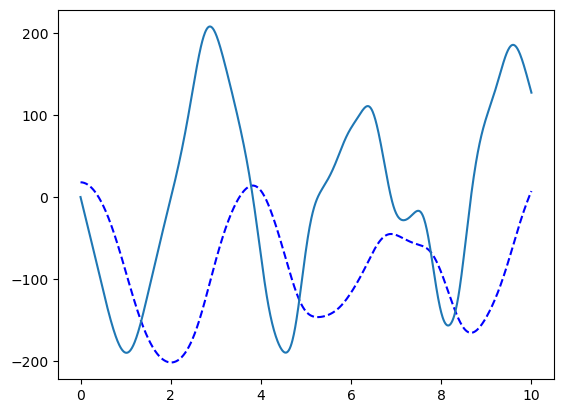

In [19]:
#plt.plot(t, the1,label= r'$\frac{d\theta_1}{dt} = \theta_2 $')
plt.plot(t, the1,'b--',label= 'theta1')
plt.plot(t, the2)